In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("C:/Users/mateo/Documents/repos/Viz_2022_Grupo_4/")


In [3]:
path = "docker\challenge_data"

#data challange
employers = pd.read_csv(path+"\Attributes\Employers.csv")
jobs = pd.read_csv(path+"\Attributes\Jobs.csv")
buildings = pd.read_csv(path+"\Attributes\Buildings.csv")

schools = pd.read_csv(path+"\Attributes\Schools.csv")
pubs = pd.read_csv(path+"\Attributes\Pubs.csv")
restos =pd.read_csv(path+"\Attributes\Restaurants.csv")

financial = pd.read_csv(path+"\Journals\FinancialJournal.csv")
checkin = pd.read_csv(path+"\Journals\CheckinJournal.csv")

# mati tabs
jobs = pd.read_csv("docker/Files/participant_job.csv",
                    delimiter = ";", header=1)
hrs_spent = pd.read_csv("docker/Files/hours_spent_in_venue.csv",
                    delimiter = ";", header=1)
# employ = pd.read_csv("docker/Files/employer_employee.csv",
#                     delimiter = ";", header=1)

employ = pd.read_csv("docker/Files/employers_log.csv",
                    delimiter = ";", header=1)

In [4]:
employ.describe()

,employerid,hires,dropouts,total_employees
count,110393.000000,110393.000000,110393.000000,110393.000000
mean,1097.406312,0.000634,0.000544,3.547897
std,506.663106,0.044637,0.038304,1.759297
min,379.000000,0.000000,0.000000,1.000000
25%,829.000000,0.000000,0.000000,2.000000
50%,1281.000000,0.000000,0.000000,3.000000
75%,1735.000000,0.000000,0.000000,5.000000
max,1797.000000,6.000000,5.000000,10.000000


In [5]:
# asigno el tipo de negocio en funcion del building ID
buildings.loc[buildings.buildingId.isin(list(set(pd.unique(restos.buildingId)) )), 
              "businessType"] = "Restaurant"
buildings.loc[buildings.buildingId.isin(list( set(pd.unique(pubs.buildingId)) )),
              "businessType"] = "Pub"
buildings.loc[buildings.buildingId.isin(list(set(pd.unique(schools.buildingId) ))),
              "businessType"] = "School"
buildings.loc[buildings.businessType.isnull(), 
              "businessType"] = "Other"

# buildings[buildings["buildingType"] =="Commercial"]
# buildings[buildings["businessType"] !="Other"]

In [27]:
# creo georeferencacion de los empleadores
employers['location_x'] = employers['location'].map(
    lambda x: x.lstrip('POINT (').rstrip(')')).str.split(' ').str[0].astype(float)

employers['location_y'] = employers['location'].map(
    lambda x: x.lstrip('POINT (').rstrip(')')).str.split(' ').str[1].astype(float)

# variables extras de empleo
employ['dt_time'] = pd.to_datetime(employ.dt)
employ['turnover'] = employ['hires']/employ['dropouts'] - 1 

#join
employers_join = pd.merge(employ,  employers,
                          how = "right", 
                          left_on = "employerid" , right_on = "employerId").drop("employerid",1) #join empleadores y cant empleados
employers_join = pd.merge(employers_join, buildings[["buildingId", "buildingType", "businessType"]], 
                          how = "left", left_on = "buildingId", right_on = "buildingId") # join con edificios

# borro employers sin contrataciones
employers_join = employers_join[- employers_join.employerId.isin( list(employers_join[employers_join.total_employees.isnull() ] .employerId ) ) ]

employers_join.head()

C:\Users\mateo\AppData\Local\Temp\ipykernel_7564\3493736022.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  left_on = "employerid" , right_on = "employerId").drop("employerid",1) #join empleadores y cant empleados


,dt,hires,dropouts,total_employees,dt_time,turnover,employerId,location,buildingId,location_x,location_y,buildingType,businessType
0,2023-05-20,0.0,0.0,1.0,2023-05-20,NaN,379,POINT (-1849.997168394888 1744.6010147106394),823,-1849.997168,1744.601015,Commercial,Other
1,2023-05-19,0.0,0.0,1.0,2023-05-19,NaN,379,POINT (-1849.997168394888 1744.6010147106394),823,-1849.997168,1744.601015,Commercial,Other
2,2023-05-18,0.0,0.0,1.0,2023-05-18,NaN,379,POINT (-1849.997168394888 1744.6010147106394),823,-1849.997168,1744.601015,Commercial,Other
3,2023-05-17,0.0,0.0,1.0,2023-05-17,NaN,379,POINT (-1849.997168394888 1744.6010147106394),823,-1849.997168,1744.601015,Commercial,Other
4,2023-05-16,0.0,0.0,1.0,2023-05-16,NaN,379,POINT (-1849.997168394888 1744.6010147106394),823,-1849.997168,1744.601015,Commercial,Other


In [10]:
employers_join["businessType"].value_counts() #no hay escuelas como empleadores

Other         98381
Restaurant     7121
Pub            4895
Name: businessType, dtype: int64

In [11]:
pd.unique(buildings.buildingType)

array(['Commercial', 'Residental', 'School'], dtype=object)

## Turnover

In [40]:
employers_join.columns

Index(['dt', 'hires', 'dropouts', 'total_employees', 'dt_time', 'turnover',
       'employerId', 'location', 'buildingId', 'location_x', 'location_y',
       'buildingType', 'businessType'],
      dtype='object')

In [138]:
agg_employ = employers_join.groupby('employerId', as_index=False).agg(
    tot_hires = ('hires', sum),
    tot_dropouts = ('dropouts', sum),
    avg_employees = ('total_employees', np.nanmean  )
)
agg_employ = pd.merge(agg_employ,  employers_join[[  'location_x', 'location_y', 
                                                   'businessType', 'buildingId', 'employerId' ]].drop_duplicates(),
                          how = "left", 
                          left_on = "employerId" , right_on = "employerId" )

agg_employ.head()

,employerId,tot_hires,tot_dropouts,avg_employees,location_x,location_y,businessType,buildingId
0,379,0.0,0.0,1.0,-1849.997168,1744.601015,Other,823
1,381,0.0,0.0,4.0,877.278658,1358.544181,Other,279
2,382,0.0,0.0,4.0,670.398740,1584.474346,Other,3
3,383,0.0,0.0,6.0,829.955678,2163.480305,Other,146
4,384,0.0,0.0,3.0,880.164488,4339.701656,Other,527


In [137]:
agg_employ.businessType.value_counts()

Other         222
Restaurant     16
Pub            11
Name: businessType, dtype: int64

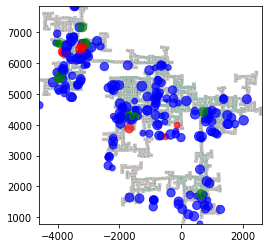

In [169]:
size = agg_employ["avg_employees"].to_numpy()
s = [np.log(s)*50 for s in size]

colors = {"Restaurant": "green", "Pub": "red", "School": "yellow", "Other": "blue"}


fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
ax.imshow(img, extent= [agg_employ.location_x.min(),
                        agg_employ.location_x.max() ,
                        agg_employ.location_y.min() ,
                        agg_employ.location_y.max() ] )
scatter = ax.scatter(agg_employ.location_x, agg_employ.location_y , s = s, 
          c = agg_employ["businessType"].map(colors), alpha = 0.7 ) 

[colorbar](https://stackoverflow.com/questions/30779712/show-matplotlib-colorbar-instead-of-legend-for-multiple-plots-with-gradually-cha)

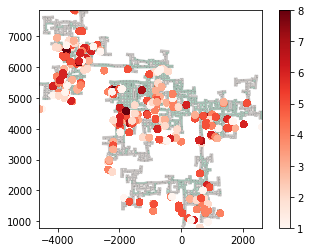

In [64]:
import matplotlib.colors as mcolors 
import matplotlib.cm as cm

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=agg_employ.avg_employees.min(), vmax=agg_employ.avg_employees.max())
colormap = cm.jet

fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
ax.imshow(img, extent= [agg_employ.location_x.min(),
                        agg_employ.location_x.max() ,
                        agg_employ.location_y.min() ,
                        agg_employ.location_y.max() ] )
scatter = ax.scatter(agg_employ.location_x, agg_employ.location_y , 
          c = agg_employ["avg_employees"] , cmap = 'Reds' ) 

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='Reds')
plt.colorbar(scalarmappaple)

# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Hires", 
#                    bbox_to_anchor=(1, 0.2))
# ax.add_artist(legend1)

(array([16943., 18245., 21360.,     0., 16910., 20915.,     0., 12015.,
         2225.,  1780.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

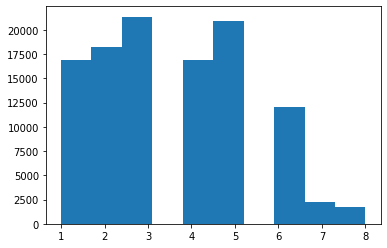

In [70]:
plt.hist(agg_employ.avg_employees)

In [69]:
employers_join.total_employees.value_counts()

3.0     21327
5.0     20954
2.0     18313
4.0     16908
1.0     16900
6.0     11977
7.0      2226
8.0      1784
9.0         2
10.0        2
Name: total_employees, dtype: int64

<AxesSubplot:xlabel='dt_time'>

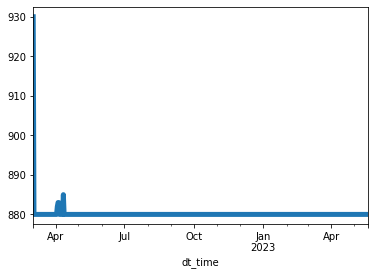

In [95]:
employers_join.groupby('dt_time')['total_employees'].sum().plot(linewidth =5)

In [100]:
employers_day =  employers_join.sort_values('dt_time').groupby('dt_time', as_index=False).agg(
    {  'total_employees' : sum ,
     'dropouts' : sum , 
    'hires' : sum} )
# employers_day[employers_day['total_employees'] > 880 ]

employers_day

,dt_time,total_employees,dropouts,hires
0,2022-03-02,930.0,51.0,61.0
1,2022-03-03,880.0,0.0,0.0
2,2022-03-04,880.0,0.0,0.0
3,2022-03-05,880.0,0.0,0.0
4,2022-03-06,880.0,0.0,0.0
...,...,...,...,...
440,2023-05-16,880.0,0.0,0.0
441,2023-05-17,880.0,0.0,0.0
442,2023-05-18,880.0,0.0,0.0
443,2023-05-19,880.0,0.0,0.0


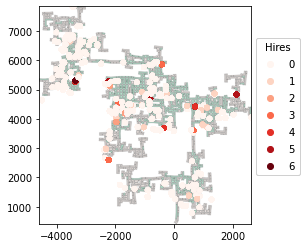

In [72]:
fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
ax.imshow(img, extent= [employers.location_x.min(),
                        employers.location_x.max() ,
                        employers.location_y.min() ,
                        employers.location_y.max() ] )
scatter = ax.scatter(agg_employ.location_x, agg_employ.location_y ,# s = s, 
          c =  agg_employ.tot_hires, cmap ='Reds', s =20) 

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Hires", 
                   bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
plt.savefig('img/06.hires.png')

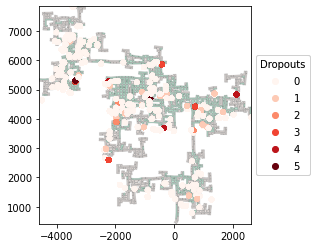

In [71]:
fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
ax.imshow(img, extent= [employers.location_x.min(),
                        employers.location_x.max() ,
                        employers.location_y.min() ,
                        employers.location_y.max() ] )
scatter = ax.scatter(agg_employ.location_x, agg_employ.location_y ,# s = s, 
          c =  agg_employ.tot_dropouts, cmap ='Reds', s =20) 

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Dropouts", 
                   bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)
plt.savefig('img/06.dropouts.png')

Dia de maxima rotacion

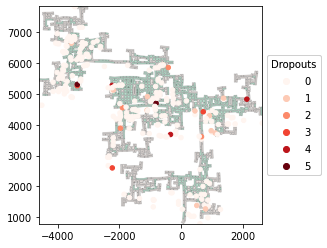

In [105]:
day_of_hires = employers_join[employers_join.dt== '2022-03-02' ]

fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
ax.imshow(img, extent= [day_of_hires.location_x.min(),
                        day_of_hires.location_x.max() ,
                        day_of_hires.location_y.min() ,
                        day_of_hires.location_y.max() ] )
scatter = ax.scatter(day_of_hires.location_x, day_of_hires.location_y ,# s = s, 
          c =  day_of_hires.dropouts, cmap ='Reds', s =20) 

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Dropouts", 
                   bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)



In [106]:
day_of_hires.describe()

,hires,dropouts,total_employees,turnover,employerId,buildingId,location_x,location_y
count,249.000000,249.000000,249.000000,26.0000,249.000000,249.000000,249.000000,249.000000
mean,0.244980,0.204819,3.734940,inf,1094.887550,517.024096,-1547.327225,4643.116039
std,0.889128,0.758166,1.963894,NaN,508.417813,303.668165,1749.682562,1558.936290
min,0.000000,0.000000,1.000000,0.0000,379.000000,3.000000,-4597.345294,787.469266
25%,0.000000,0.000000,2.000000,0.0000,829.000000,261.000000,-3257.563510,4008.345280
50%,0.000000,0.000000,4.000000,0.0000,1281.000000,485.000000,-1590.604526,4771.135721
75%,0.000000,0.000000,5.000000,0.3125,1735.000000,782.000000,-271.316030,5847.491402
max,6.000000,5.000000,10.000000,inf,1797.000000,1041.000000,2630.000000,7836.545593


# Revenue by employeer


## Pubs

In [140]:
pubs_spents = pd.merge(hrs_spent[hrs_spent['venuetype']== 'Pub'] ,
                       pd.merge(agg_employ,
                                pubs[['buildingId', 'hourlyCost', 'pubId']],
                                how ='left', left_on ='buildingId',  right_on ='buildingId' ) ,                       
        how = "left" , right_on = ['pubId'],
                        left_on = ["venueid"] )

pubs_spents["spents"] = pubs_spents.hourlyCost * pubs_spents.hour_diff
pubs_spents.head()

,participantid,from_timestamp,to_timestamps,hour_diff,venueid,venuetype,employerId,tot_hires,tot_dropouts,avg_employees,location_x,location_y,businessType,buildingId,hourlyCost,pubId,spents
0,619,3/1/22,3/1/22,2.0,1798,Pub,1745.0,0.0,0.0,6.0,-3209.738139,6557.838945,Pub,953.0,11.545351,1798.0,23.090702
1,619,3/1/22,3/1/22,2.0,1798,Pub,1766.0,0.0,0.0,4.0,-3209.738139,6522.748317,Pub,953.0,11.545351,1798.0,23.090702
2,619,3/1/22,3/1/22,2.0,1798,Pub,1795.0,0.0,0.0,6.0,-3267.606055,6452.567059,Pub,953.0,11.545351,1798.0,23.090702
3,619,3/1/22,3/1/22,2.0,1800,Pub,1738.0,0.0,0.0,2.0,-3796.119851,6367.922073,Pub,627.0,10.206845,1800.0,20.413691
4,619,3/1/22,3/1/22,2.0,1800,Pub,1768.0,0.0,0.0,5.0,-3837.722151,6367.922073,Pub,627.0,10.206845,1800.0,20.413691


In [148]:
pubs_spents[['pubId', 'employerId']].drop_duplicates()

,pubId,employerId
0,1798.0,1745.0
1,1798.0,1766.0
2,1798.0,1795.0
3,1800.0,1738.0
4,1800.0,1768.0
5,1800.0,1770.0
6,1344.0,1331.0
11,NaN,NaN
33,1342.0,1312.0


<AxesSubplot:xlabel='pubId,employerId'>

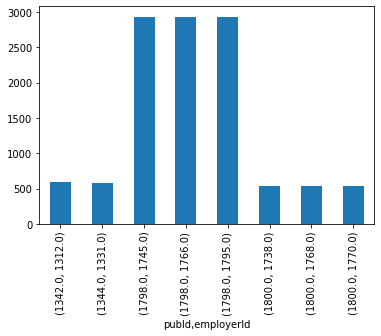

In [149]:
pubs_spents.groupby(['pubId', 'employerId'])['spents'].sum().plot.bar()

In [145]:
pd.unique(pubs_spents.pubId)

array([1798., 1800., 1344.,   nan, 1342.])

In [186]:
pub_employ 

,employerId,tot_hires,tot_dropouts,avg_employees,location_x,location_y,businessType,buildingId
89,859,0.0,0.0,5.0,-1684.567984,3880.071128,Pub,238
123,1280,0.0,0.0,2.0,-501.426761,3608.072271,Pub,489
155,1312,0.0,0.0,1.0,-271.316030,4985.574640,Pub,429
174,1331,0.0,0.0,2.0,-129.406007,3983.301589,Pub,585
178,1335,0.0,0.0,1.0,-459.474168,3608.072271,Pub,489
189,1738,0.0,0.0,2.0,-3796.119851,6367.922073,Pub,627
196,1745,0.0,0.0,6.0,-3209.738139,6557.838945,Pub,953
217,1766,0.0,0.0,4.0,-3209.738139,6522.748317,Pub,953
219,1768,0.0,0.0,5.0,-3837.722151,6367.922073,Pub,627
221,1770,0.0,0.0,5.0,-3796.119851,6330.793190,Pub,627


C:\Users\mateo\AppData\Local\Temp\ipykernel_7564\2530181517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub_employ['employerId'] =pub_employ['employerId'].astype(int)


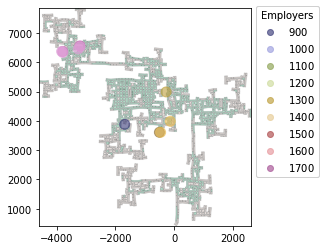

In [192]:
fig, ax = plt.subplots()
img = plt.imread("data/BaseMap.png")
pub_employ =agg_employ[agg_employ['businessType']== 'Pub' ]
pub_employ['employerId'] =pub_employ['employerId'].astype(int)

ax.imshow(img, extent= [employers.location_x.min(),
                        employers.location_x.max() ,
                        employers.location_y.min() ,
                        employers.location_y.max() ] )
scatter = ax.scatter(pub_employ.location_x, pub_employ.location_y , 
                      c = pub_employ["employerId"] , cmap = 'tab20b',
                     s= 100, alpha = 0.6)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Employers", 
                   bbox_to_anchor=(1, 0.2))
ax.add_artist(legend1)

## Restaurants

In [151]:
resto_spents = pd.merge(hrs_spent[hrs_spent['venuetype']== 'Restaurant'] ,
                       pd.merge(agg_employ,
                                restos[['buildingId', 'foodCost', 'restaurantId']],
                                how ='left', left_on ='buildingId',  right_on ='buildingId' ) ,                       
        how = "left" , right_on = ['restaurantId'],
                        left_on = ["venueid"] )

# pubs_spents["spents"] = pubs_spents.hourlyCost * pubs_spents.hour_diff
resto_spents.head()

,participantid,from_timestamp,to_timestamps,hour_diff,venueid,venuetype,employerId,tot_hires,tot_dropouts,avg_employees,location_x,location_y,businessType,buildingId,foodCost,restaurantId
0,619,3/2/22,3/2/22,0.0,1803,Restaurant,1782,0.0,0.0,5.000000,-3205.791803,7158.990636,Restaurant,213,4.35,1803.0
1,619,3/9/22,3/9/22,0.0,1803,Restaurant,1782,0.0,0.0,5.000000,-3205.791803,7158.990636,Restaurant,213,4.35,1803.0
2,619,3/13/22,3/13/22,0.0,448,Restaurant,429,4.0,3.0,5.006742,715.908669,4418.132191,Restaurant,964,4.07,448.0
3,619,3/16/22,3/16/22,0.0,1803,Restaurant,1782,0.0,0.0,5.000000,-3205.791803,7158.990636,Restaurant,213,4.35,1803.0
4,619,3/22/22,3/22/22,0.0,1803,Restaurant,1782,0.0,0.0,5.000000,-3205.791803,7158.990636,Restaurant,213,4.35,1803.0


<AxesSubplot:xlabel='restaurantId,employerId'>

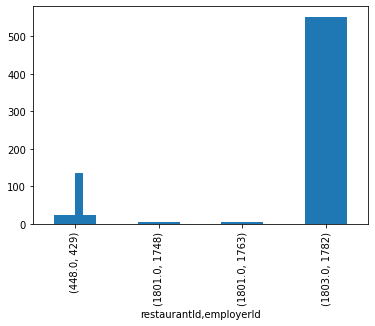

In [159]:
plt.hist(resto_spents.hour_diff)
resto_spents.groupby(['restaurantId', 'employerId'])['foodCost'].sum().plot.bar()

In [158]:
business_revenues = pd.read_csv("docker/Files/business_revenues.csv",
                    delimiter = ";", header=1)
business_revenues#.venuetype.value_counts()

,dt,venuetype,venueid,revenue,Unnamed: 4
0,11/8/22,Pub,443,"250,27998021",NaN
1,3/23/23,Pub,893,"623,2998513",NaN
2,10/28/22,Pub,894,"393,95872128",NaN
3,4/18/23,Pub,1342,"805,982082209999",NaN
4,1/27/23,Pub,893,"563,9379607",NaN
...,...,...,...,...,...
26762,11/30/22,Restaurant,1802,"187,96",NaN
26763,1/11/23,Restaurant,899,"350,3",NaN
26764,3/15/22,Restaurant,1349,"66,78",NaN
26765,3/21/22,Restaurant,1345,"192,7",NaN
